# BIAS - EMBEDDINGS

* with Pneumonia only
* with Pneumonia and other diseases
* with No Findings

In [1]:
import os
import base64
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
sys.path.append("/mnt/data2/datasets_lfay/MedImageInsights")
from MedImageInsight.medimageinsightmodel import MedImageInsight

# Load MedImageInsight model
PATH_TO_DATA = "/mnt/data2/datasets_lfay/MedImageInsights/data"
MODEL_DIR = "/mnt/data2/datasets_lfay/MedImageInsights/MedImageInsight/2024.09.27"
classifier = MedImageInsight(
    model_dir=MODEL_DIR,
    vision_model_name="medimageinsigt-v1.0.0.pt",
    language_model_name="language_model.pth"
)
classifier.load_model()

# Define dataset configuration
dataset = "CheXpert-v1.0-512"
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, dataset, "test.csv"))

bias_variables = {
    "sex": {"Female": lambda df: df["sex"] == "Female", "Male": lambda df: df["sex"] == "Male"},
    "age": {"Young": lambda df: df["age"] <= 62, "Old": lambda df: df["age"] > 62},
    "race": {
        "White": lambda df: df["race"] == "White",
        "Asian": lambda df: df["race"] == "Asian",
        "Black": lambda df: df["race"] == "Black",
    },
}


/mnt/data2/datasets_lfay/MedImageInsights/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully on device: cuda


In [5]:
def get_subgroup_data(df, variable, conditions):
    labels = []
    subgroup_data = []

    for label, condition in conditions.items():
        subgroup = df[condition(df)]
        subgroup = subgroup[subgroup.Pneumonia==1]
        labels.extend([label] * len(subgroup))
        subgroup_data.append(subgroup)

    combined_df = pd.concat(subgroup_data, ignore_index=True)
    return combined_df, labels

In [6]:
def extract_embeddings(df, classifier, dataset_path):
    """
    Extract embeddings for a given dataset using the classifier.
    Args:
        df (DataFrame): DataFrame containing image paths.
        classifier: Initialized MedImageInsight classifier.
        dataset_path (str): Path to the dataset.

    Returns:
        np.ndarray: Array of embeddings.
    """
    embeddings = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting embeddings"):
        image_path = os.path.join(dataset_path, row["Path"].lstrip("/"))
        with open(image_path, "rb") as img_file:
            image_base64 = base64.encodebytes(img_file.read()).decode("utf-8")
        embedding = classifier.encode(images=[image_base64])["image_embeddings"]
        embeddings.append(embedding[0])
    return np.array(embeddings)

In [7]:
# Plot t-SNE scatter and 1D KDE in a single figure
def plot_tsne_subplots(embeddings, labels, variable, output_path=None):
    tsne_results = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(embeddings)
    tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])
    tsne_df["label"] = labels

    # Create a 3x3 subplot layout
    fig, axes = plt.subplots(3, 3, figsize=(18, 12), gridspec_kw={"height_ratios": [3, 1, 1]})

    for i, (var, cond) in enumerate(bias_variables.items()):
        # Top row: 2D scatter plot
        sns.scatterplot(
            ax=axes[0, i],
            data=tsne_df,
            x="x",
            y="y",
            hue="label",
            alpha=0.7,
            palette="Set1"
        )
        axes[0, i].set_title(f"t-SNE Visualization - {var.capitalize()}")
        axes[0, i].set_xlabel("t-SNE Dimension 1")
        axes[0, i].set_ylabel("t-SNE Dimension 2")
        axes[0, i].legend(title=variable.capitalize(), loc="best")

        # Middle row: KDE for Dimension 1
        sns.kdeplot(
            ax=axes[1, i],
            data=tsne_df,
            x="x",
            hue="label",
            common_norm=False,
            fill=True,
            alpha=0.4,
            palette="Set1"
        )
        axes[1, i].set_title(f"Dimension 1 Distribution - {var.capitalize()}")
        axes[1, i].set_xlabel("t-SNE Dimension 1")
        axes[1, i].set_ylabel("Density")

        # Bottom row: KDE for Dimension 2
        sns.kdeplot(
            ax=axes[2, i],
            data=tsne_df,
            x="y",
            hue="label",
            common_norm=False,
            fill=True,
            alpha=0.4,
            palette="Set1"
        )
        axes[2, i].set_title(f"Dimension 2 Distribution - {var.capitalize()}")
        axes[2, i].set_xlabel("t-SNE Dimension 2")
        axes[2, i].set_ylabel("Density")

        # Remove legends for individual subplots
        axes[1, i].legend_.remove()
        axes[2, i].legend_.remove()

    # Add a single legend for all subplots
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, title="Label")

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if output_path:
        plt.savefig(output_path)
    plt.show()


Extracting embeddings: 100%|██████████| 930/930 [01:26<00:00, 10.71it/s]


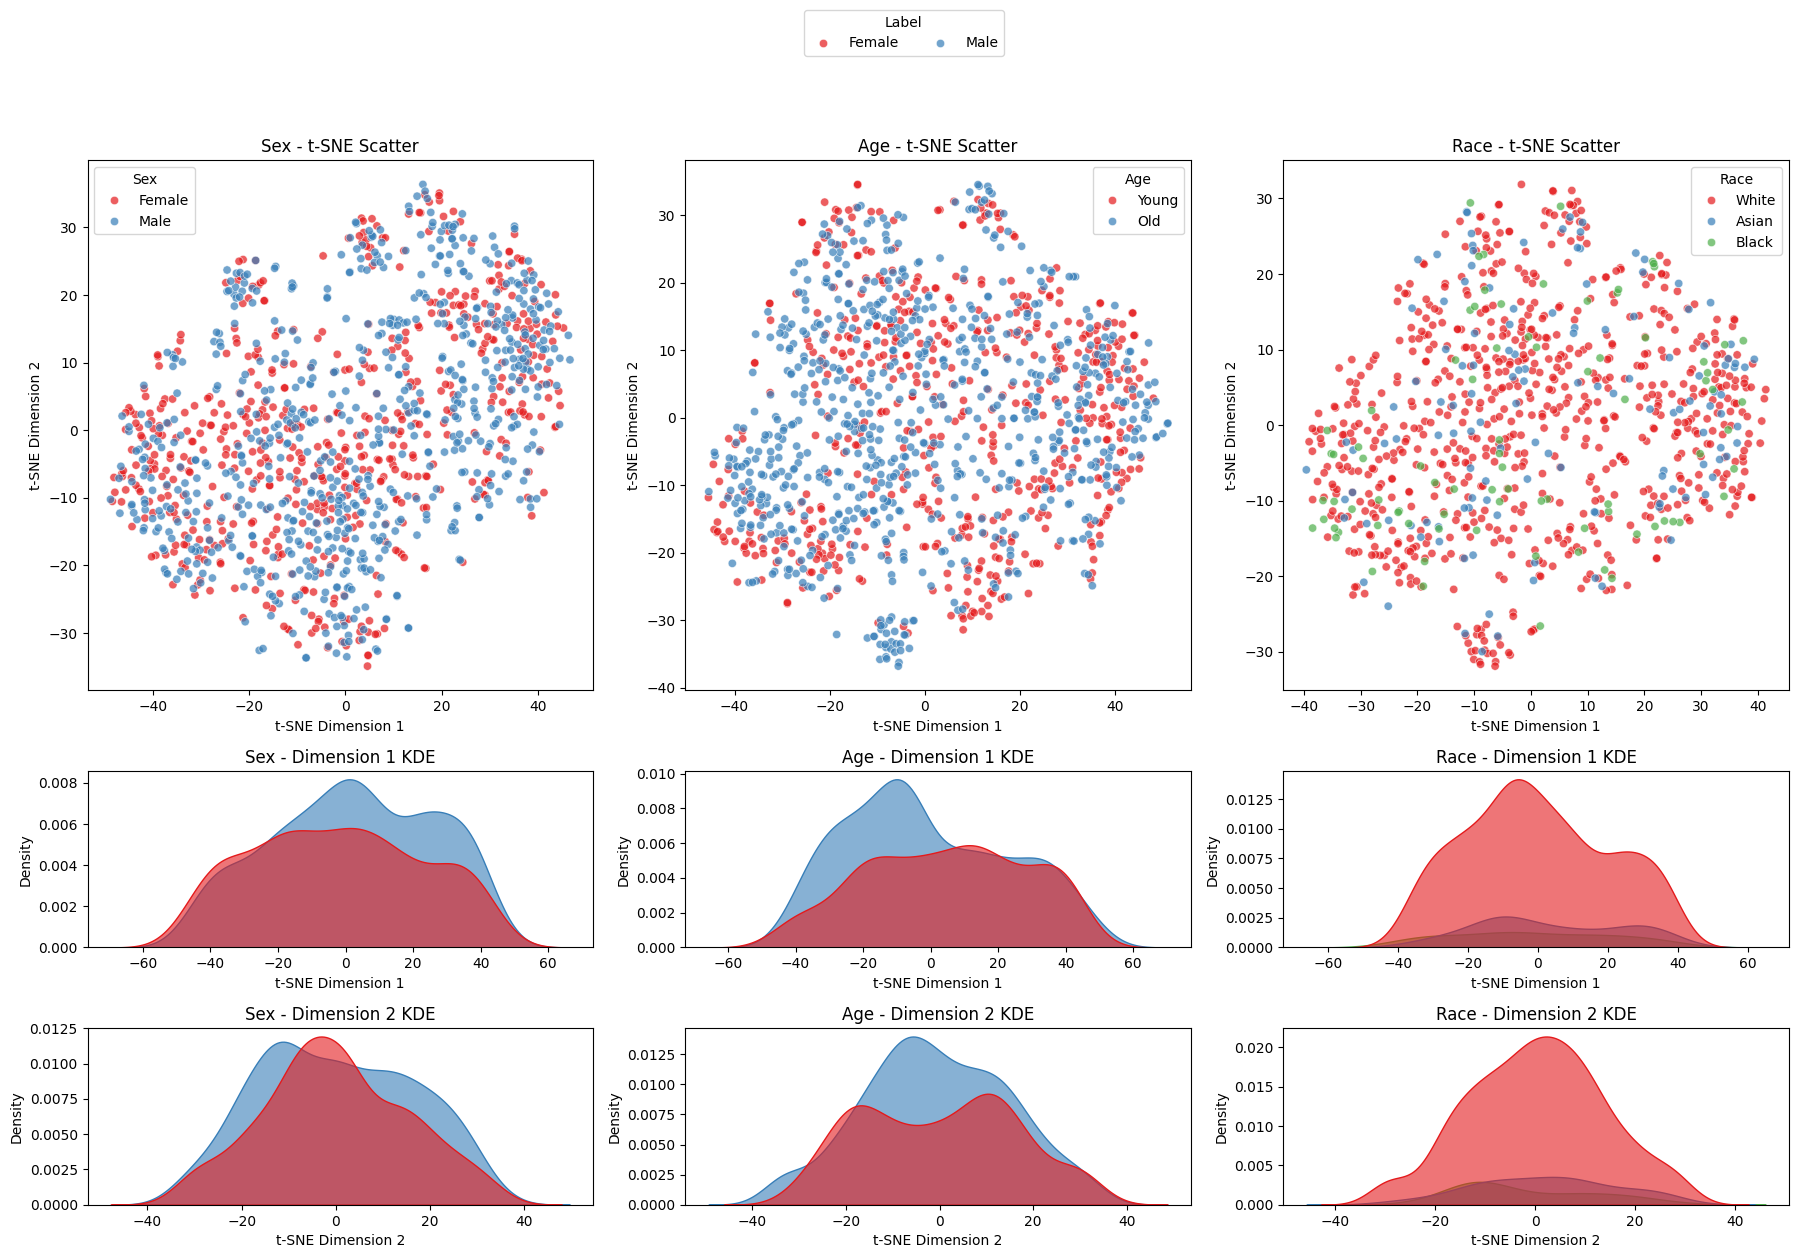

In [13]:
# Initialize Plot
fig, axes = plt.subplots(3, 3, figsize=(18, 12), gridspec_kw={"height_ratios": [3, 1, 1]})

for col_idx, (variable, conditions) in enumerate(bias_variables.items()):
    # Get subgroup data
    combined_df, labels = get_subgroup_data(df_test, variable, conditions)

    # Extract embeddings
    embeddings = extract_embeddings(combined_df, classifier, PATH_TO_DATA)

    # Perform t-SNE
    tsne_results = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(embeddings)
    tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])
    tsne_df["label"] = labels

    # Row 1: Scatter plot
    sns.scatterplot(
        ax=axes[0, col_idx], data=tsne_df, x="x", y="y", hue="label", alpha=0.7, palette="Set1"
    )
    axes[0, col_idx].set_title(f"{variable.capitalize()} - t-SNE Scatter")
    axes[0, col_idx].set_xlabel("t-SNE Dimension 1")
    axes[0, col_idx].set_ylabel("t-SNE Dimension 2")
    axes[0, col_idx].legend(title=variable.capitalize(), loc="best")

    # Row 2: KDE plot for Dimension 1
    sns.kdeplot(
        ax=axes[1, col_idx], data=tsne_df, x="x", hue="label", fill=True, alpha=0.6, palette="Set1"
    )
    axes[1, col_idx].set_title(f"{variable.capitalize()} - Dimension 1 KDE")
    axes[1, col_idx].set_xlabel("t-SNE Dimension 1")
    axes[1, col_idx].set_ylabel("Density")
    axes[1, col_idx].legend_.remove()

    # Row 3: KDE plot for Dimension 2
    sns.kdeplot(
        ax=axes[2, col_idx], data=tsne_df, x="y", hue="label", fill=True, alpha=0.6, palette="Set1"
    )
    axes[2, col_idx].set_title(f"{variable.capitalize()} - Dimension 2 KDE")
    axes[2, col_idx].set_xlabel("t-SNE Dimension 2")
    axes[2, col_idx].set_ylabel("Density")
    axes[2, col_idx].legend_.remove()

# Add a single legend for the entire figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, title="Label")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()